# Data Loading and data preperation

In [10]:
import scipy.io
mat=scipy.io.loadmat('WLDataCW.mat')

In [11]:
import pandas as pd
data=mat['data']

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  This is separate from the ipykernel package so we ca

In [173]:
df_1=data.transpose()
df_1.shape

(360, 512, 62)

In [319]:
labels=mat['label'][0].tolist()

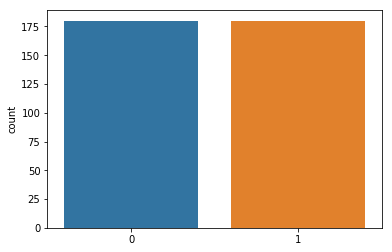

In [323]:
sns.countplot(labels)

In [321]:
#randomly shuffle data
from sklearn.utils import shuffle
X, y = shuffle(df_1, labels, random_state=32)

# Neural Network Scratch

In [92]:
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [93]:
import numpy as np

# inherit from base class Layer
class FullyConnectedLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [95]:
class ActivationLayer(Layer):
    def __init__(self, activation, activation_cap):
        self.activation = activation
        self.activation_cap = activation_cap

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_cap(self.input) * output_error

In [97]:
import numpy as np

# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_cap(x):
    return 1-np.tanh(x)**2;

In [101]:
import numpy as np

# loss function and its derivative
def meansquareerror(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def meansquareerror_cap(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

In [243]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_cap = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_cap):
        self.loss = loss
        self.loss_cap = loss_cap

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        error_list=[]
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_cap(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))
            error_list.append(err)
        return error_list

In [287]:
#distribute data for training
x_train=X[:288].reshape(288,1,512*62)
y_train=np.array(y[:288])

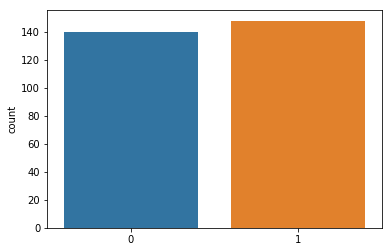

In [288]:
#plot counts of target distributed in training data
import seaborn as sns
sns.countplot(y_train)

# Implement Scratch Neural Network

In [289]:
#made neural network for training using tanh activation function
net = Network()
net.add(FullyConnectedLayer(512*62, 50))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FullyConnectedLayer(50, 10))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FullyConnectedLayer(10, 5))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FullyConnectedLayer(5, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(meansquareerror, meansquareerror_cap)
#Train initiate with 100epochs
error=net.fit(x_train, y_train, epochs=100, learning_rate=0.1)

epoch 1/100   error=0.327526
epoch 2/100   error=0.282543
epoch 3/100   error=0.275654
epoch 4/100   error=0.265422
epoch 5/100   error=0.249779
epoch 6/100   error=0.227827
epoch 7/100   error=0.200007
epoch 8/100   error=0.194893
epoch 9/100   error=0.177483
epoch 10/100   error=0.175671
epoch 11/100   error=0.190254
epoch 12/100   error=0.161425
epoch 13/100   error=0.148574
epoch 14/100   error=0.159451
epoch 15/100   error=0.131129
epoch 16/100   error=0.130885
epoch 17/100   error=0.113004
epoch 18/100   error=0.105439
epoch 19/100   error=0.099681
epoch 20/100   error=0.091472
epoch 21/100   error=0.090632
epoch 22/100   error=0.085104
epoch 23/100   error=0.098638
epoch 24/100   error=0.115566
epoch 25/100   error=0.138869
epoch 26/100   error=0.096709
epoch 27/100   error=0.084946
epoch 28/100   error=0.079366
epoch 29/100   error=0.081874
epoch 30/100   error=0.087898
epoch 31/100   error=0.087041
epoch 32/100   error=0.108192
epoch 33/100   error=0.139676
epoch 34/100   erro

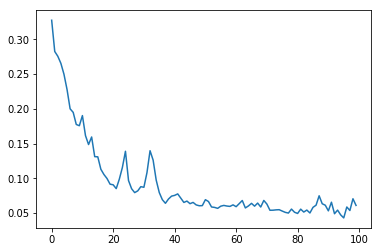

In [290]:
#plot training error
import matplotlib.pyplot as plt
plt.plot(error)
plt.show()

In [304]:
#make predictions on test/validation data
y_pred=net.predict(X[289:].reshape(X[289:].shape[0],1,512*62))
y_actual=y[289:]

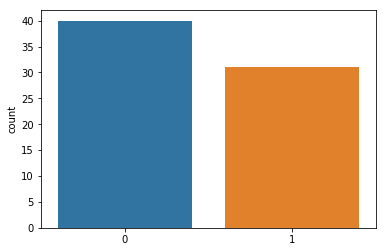

In [305]:
#distribution target in test data
sns.countplot(y_actual)

In [306]:
#applied softmax activation here
y_pred_list=[]
for i in range(len(y_pred)):
    if(y_pred[i][0][0]>0.5):
        y_pred_list.append(1)
    elif(y_pred[i][0][0]<=0.5):
        y_pred_list.append(0)

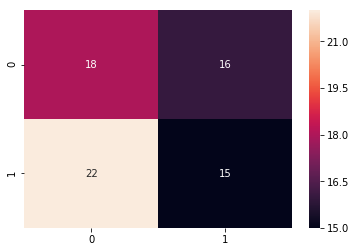

In [325]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_pred_list,y_actual)
sns.heatmap(cm,annot=True)

In [308]:
accuracy=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
accuracy

0.4647887323943662

# using Library

In [296]:
#create data for training using support of library
x_train=X[:288].reshape(288,512,62,1)
y_train=np.array(y[:288])

In [267]:
#here we are using a CNN model for training and adding dense layers for final predictions using sigmoid activation
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam

def cnn_Neural_Net():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=x_train[0].shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    opt=Adam(lr=0.0001)#optimizer
#model compile
    model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model


In [297]:
#create data for validation
x_test=X[289:].reshape(X[289:].shape[0],512,62,1)
y_test=y[289:]

In [269]:
#a special cell which calculates cross validation score using cv=5
classifier = KerasClassifier(build_fn = cnn_Neural_Net,epochs = 50,batch_size=20)
accuracies = cross_val_score(estimator=classifier,X = x_train,y = y_train,cv=5)

Epoch 1/50
230/230 [==============================] - 9s 38ms/step - loss: 1.0765 - accuracy: 0.5391
Epoch 2/50
230/230 [==============================] - 10s 43ms/step - loss: 0.8350 - accuracy: 0.6000
Epoch 3/50
230/230 [==============================] - 10s 42ms/step - loss: 0.7690 - accuracy: 0.6043
Epoch 4/50
230/230 [==============================] - 10s 43ms/step - loss: 0.6744 - accuracy: 0.6391
Epoch 5/50
230/230 [==============================] - 10s 43ms/step - loss: 0.5884 - accuracy: 0.7478
Epoch 6/50
230/230 [==============================] - 10s 42ms/step - loss: 0.5432 - accuracy: 0.7217
Epoch 7/50
230/230 [==============================] - 10s 43ms/step - loss: 0.5464 - accuracy: 0.7304
Epoch 8/50
230/230 [==============================] - 10s 45ms/step - loss: 0.5006 - accuracy: 0.7870
Epoch 9/50
230/230 [==============================] - 10s 43ms/step - loss: 0.4302 - accuracy: 0.8348
Epoch 10/50
230/230 [==============================] - 10s 41ms/step - loss: 0.3853

230/230 [==============================] - 9s 41ms/step - loss: 0.0528 - accuracy: 0.9826
Epoch 31/50
230/230 [==============================] - 10s 42ms/step - loss: 0.0842 - accuracy: 0.9609
Epoch 32/50
230/230 [==============================] - 10s 42ms/step - loss: 0.0636 - accuracy: 0.9826
Epoch 33/50
230/230 [==============================] - 10s 43ms/step - loss: 0.0610 - accuracy: 0.9870
Epoch 34/50
230/230 [==============================] - 10s 43ms/step - loss: 0.0522 - accuracy: 0.9913
Epoch 35/50
230/230 [==============================] - 9s 41ms/step - loss: 0.0632 - accuracy: 0.9783
Epoch 36/50
230/230 [==============================] - 9s 41ms/step - loss: 0.0606 - accuracy: 0.9870
Epoch 37/50
230/230 [==============================] - 9s 41ms/step - loss: 0.0550 - accuracy: 0.9739
Epoch 38/50
230/230 [==============================] - 10s 42ms/step - loss: 0.0459 - accuracy: 0.9783
Epoch 39/50
230/230 [==============================] - 10s 42ms/step - loss: 0.0562 - acc

231/231 [==============================] - 9s 41ms/step - loss: 0.4370 - accuracy: 0.8225
Epoch 10/50
231/231 [==============================] - 9s 41ms/step - loss: 0.4157 - accuracy: 0.8485
Epoch 11/50
231/231 [==============================] - 9s 41ms/step - loss: 0.3307 - accuracy: 0.8961
Epoch 12/50
231/231 [==============================] - 9s 41ms/step - loss: 0.3232 - accuracy: 0.9004
Epoch 13/50
231/231 [==============================] - 10s 41ms/step - loss: 0.2680 - accuracy: 0.9264
Epoch 14/50
231/231 [==============================] - 10s 42ms/step - loss: 0.2776 - accuracy: 0.8961
Epoch 15/50
231/231 [==============================] - 10s 41ms/step - loss: 0.3460 - accuracy: 0.8658
Epoch 16/50
231/231 [==============================] - 10s 42ms/step - loss: 0.3046 - accuracy: 0.8874
Epoch 17/50
231/231 [==============================] - 9s 41ms/step - loss: 0.2670 - accuracy: 0.9221
Epoch 18/50
231/231 [==============================] - 9s 41ms/step - loss: 0.1977 - accur

231/231 [==============================] - 10s 42ms/step - loss: 0.1002 - accuracy: 0.9740
Epoch 39/50
231/231 [==============================] - 10s 43ms/step - loss: 0.0959 - accuracy: 0.9784
Epoch 40/50
231/231 [==============================] - 10s 41ms/step - loss: 0.0821 - accuracy: 0.9697
Epoch 41/50
231/231 [==============================] - 9s 41ms/step - loss: 0.0749 - accuracy: 0.9870
Epoch 42/50
231/231 [==============================] - 10s 42ms/step - loss: 0.0927 - accuracy: 0.9784
Epoch 43/50
231/231 [==============================] - 12s 50ms/step - loss: 0.1043 - accuracy: 0.9654
Epoch 44/50
231/231 [==============================] - 11s 46ms/step - loss: 0.1032 - accuracy: 0.9481
Epoch 45/50
231/231 [==============================] - 11s 49ms/step - loss: 0.1168 - accuracy: 0.9697
Epoch 46/50
231/231 [==============================] - 11s 47ms/step - loss: 0.1102 - accuracy: 0.9567
Epoch 47/50
231/231 [==============================] - 10s 43ms/step - loss: 0.0827 - 

In [271]:
#accuracies mean and standard deviation using k-cross validation
print(accuracies.mean(),accuracies.std())

0.8993345379829407 0.03335489789096409


In [298]:
model_cnn=cnn_Neural_Net()

In [324]:
print(model_cnn.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 510, 60, 32)       320       
_________________________________________________________________
activation_136 (Activation)  (None, 510, 60, 32)       0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 255, 30, 32)       0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 253, 28, 32)       9248      
_________________________________________________________________
activation_137 (Activation)  (None, 253, 28, 32)       0         
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 126, 14, 32)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 124, 12, 64)     

In [299]:
history=model_cnn.fit(x=x_train,y=y_train,epochs=100,validation_data=(x_test,y_test))

Train on 288 samples, validate on 71 samples
Epoch 1/100
288/288 [==============================] - 13s 44ms/step - loss: 0.9647 - accuracy: 0.5312 - val_loss: 0.6880 - val_accuracy: 0.5211
Epoch 2/100
288/288 [==============================] - 13s 44ms/step - loss: 0.7817 - accuracy: 0.5278 - val_loss: 0.6833 - val_accuracy: 0.6901
Epoch 3/100
288/288 [==============================] - 14s 47ms/step - loss: 0.7157 - accuracy: 0.5729 - val_loss: 0.7006 - val_accuracy: 0.2958
Epoch 4/100
288/288 [==============================] - 14s 48ms/step - loss: 0.6955 - accuracy: 0.5069 - val_loss: 0.6929 - val_accuracy: 0.4225
Epoch 5/100
288/288 [==============================] - 14s 49ms/step - loss: 0.6362 - accuracy: 0.6146 - val_loss: 0.6667 - val_accuracy: 0.6197
Epoch 6/100
288/288 [==============================] - 13s 45ms/step - loss: 0.6373 - accuracy: 0.6007 - val_loss: 0.6964 - val_accuracy: 0.5634
Epoch 7/100
288/288 [==============================] - 13s 45ms/step - loss: 0.6253 -

Epoch 57/100
288/288 [==============================] - 13s 45ms/step - loss: 0.0837 - accuracy: 0.9688 - val_loss: 0.3949 - val_accuracy: 0.8732
Epoch 58/100
288/288 [==============================] - 13s 45ms/step - loss: 0.1098 - accuracy: 0.9479 - val_loss: 0.4778 - val_accuracy: 0.8732
Epoch 59/100
288/288 [==============================] - 13s 46ms/step - loss: 0.0822 - accuracy: 0.9514 - val_loss: 0.5859 - val_accuracy: 0.8592
Epoch 60/100
288/288 [==============================] - 13s 45ms/step - loss: 0.0981 - accuracy: 0.9549 - val_loss: 0.4422 - val_accuracy: 0.8732
Epoch 61/100
288/288 [==============================] - 13s 45ms/step - loss: 0.0793 - accuracy: 0.9653 - val_loss: 0.3678 - val_accuracy: 0.8873
Epoch 62/100
288/288 [==============================] - 13s 45ms/step - loss: 0.0817 - accuracy: 0.9722 - val_loss: 0.5363 - val_accuracy: 0.8732
Epoch 63/100
288/288 [==============================] - 13s 44ms/step - loss: 0.0780 - accuracy: 0.9757 - val_loss: 0.4532 -

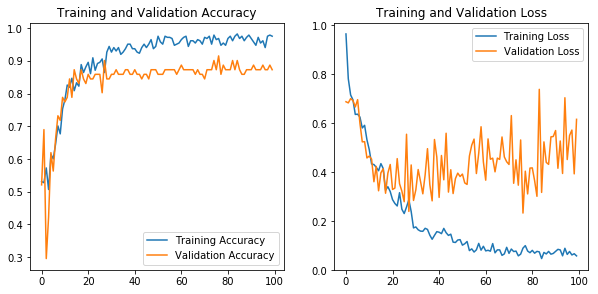

In [309]:
#plot graphs of training accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
#plot graphs of training accuracy and validation accuracy
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
#plot graphs of training loss and validation loss
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [310]:
#classification report
from sklearn.metrics import classification_report,confusion_matrix
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91        40
           1       0.85      0.94      0.89        31

   micro avg       0.90      0.90      0.90        71
   macro avg       0.90      0.91      0.90        71
weighted avg       0.91      0.90      0.90        71



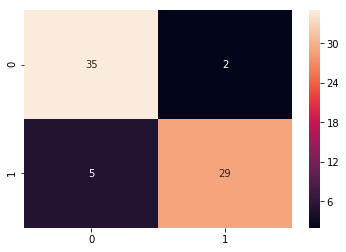

In [326]:
#confusion matrix
cm=confusion_matrix(predictions,y_test)
sns.heatmap(cm,annot=True)

In [312]:
#accuracy
accuracy=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
accuracy

0.9014084507042254